In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from torch.optim import SGD
from torchsummary import summary

# Assign seed for repeatability
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Download Fashion MNIST

In [2]:
# Define a directory to store the data
data_dir = "~/data/"

# Download the Fashion MNIST dataset
fmnist = datasets.FashionMNIST(data_dir, download=True)

In [3]:
fmnist

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: /root/data/
    Split: Train

In [4]:
# Get the data and the targets
x = fmnist.data
print("Number of training samples:", x.shape[0])
print("Shape of the images: {} x {}".format(x.shape[1], x.shape[2]))
y = fmnist.targets
print("Number of classes:", len(y.unique()))
print("Class names:", fmnist.classes)

Number of training samples: 60000
Shape of the images: 28 x 28
Number of classes: 10
Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


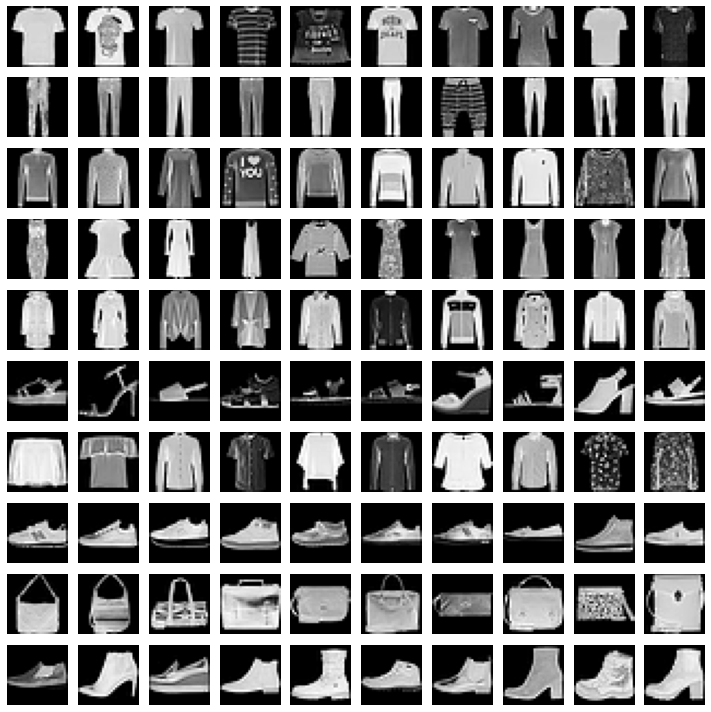

In [5]:
# Plot a random sample of the images. 
# We will plot a 10x10 grid. Each row in the grid will represent a class
n_rows = len(y.unique())
n_cols = 10

fig, ax = plt.subplots(n_rows, n_cols, figsize=(10, 10))
for c, row in enumerate(ax):
  c_ix = np.where(y == c)[0]  # Get the indices for each class
  for cell in row:
    cell.grid(False)
    cell.axis("off")
    rand_ix = np.random.choice(c_ix)
    rand_x, rand_y = x[rand_ix], y[rand_ix]
    cell.imshow(rand_x, cmap='gray')
plt.tight_layout()
plt.show()

In [6]:
# Download the validation data
fmnist_val = datasets.FashionMNIST(data_dir, train=False, download=True)

# Validation images and labels
x_val = fmnist_val.data
y_val = fmnist_val.targets

# Fetch batches of data

In [7]:
# Define a class the fetches a data point
class fetch_dataset(Dataset):
  def __init__(self, x, y):
    x = x.float()
    # Scale the values
    x = x/255.
    # Flatten the input
    x = x.view(-1, 1, x.shape[1], x.shape[2])
    self.x = x
    self.y = y

  def __len__(self):
    return len(self.x)

  def __getitem__(self, ix):
    return self.x[ix], self.y[ix]

In [8]:
def get_data(x, y, batch_size, x_val, y_val):

  # Reproducibility for data loader
  def _seed_worker(worker_id):
    worker_seed = SEED
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

  # Train data
  ds = fetch_dataset(x, y)
  # Define dataloader to fetch batches of data
  dl = DataLoader(ds, batch_size=batch_size, shuffle=True,
                  worker_init_fn=_seed_worker)
  
  # Validation data
  ds_val = fetch_dataset(x_val, y_val)
  dl_val = DataLoader(ds_val, batch_size=len(x_val),
                      shuffle=False)

  return dl, dl_val

# Define model architecture

In this tutorial, we will define a feedforward neural net.

In [9]:
n_feat = x.shape[1] * x.shape[2]
print("Number of features:", n_feat)

Number of features: 784


In [10]:
class FFNeuralNet(nn.Module):
  def __init__(self):
    super().__init__()

    # Number of neurons in each fully connected layer
    self.n_fc1 = 512

    # Number of neurons in the output layer
    self.n_op = len(y.unique())

    # Operations at each hidden layer
    self.conv1 = nn.Conv2d(1, 64, kernel_size=3)
    self.conv1_act = nn.ReLU()
    self.max_pool1 = nn.MaxPool2d(kernel_size=2)
    self.conv2 = nn.Conv2d(64, 128, kernel_size=3)
    self.conv2_act = nn.ReLU()
    self.max_pool2 = nn.MaxPool2d(kernel_size=2)
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(3200, self.n_fc1)
    self.fc1_act = nn.ReLU()
    self.fc2 = nn.Linear(self.n_fc1, self.n_op)
    self.op_act = nn.Softmax(dim=1)

  def forward(self, x):

    x = self.conv1(x)
    x = self.conv1_act(x)
    x = self.max_pool1(x)
    x = self.conv2(x)
    x = self.conv2_act(x)
    x = self.max_pool2(x)
    x = self.flatten(x)
    # Method 1: Determine number of nodes after convolution operations
    # print(x.size())
    x = self.fc1(x)
    x = self.fc1_act(x)
    x = self.fc2(x)
    x = self.op_act(x)

    return x

In [11]:
def get_model():

  # Assign seed to PyTorch for repeatability
  torch.manual_seed(SEED)

  # Create a model instance
  model = FFNeuralNet()
  
  return model

In [12]:
# Method 2: Print summary of model to determine the number of 
# nodes after convolution operation
# model_summ = get_model()
# summary(model_summ.cuda(), input_size=(1, x.shape[1], x.shape[2]))

# Train the model

In [13]:
# Train the model on GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [14]:
# Calculate loss and perform backpropagation
def wt_update(model, x, y, loss_fn):

  # Flush the weights
  opt.zero_grad()
  # Determine the batch loss
  loss_val = loss_fn(model(x), y)
  # Perform backpropagation
  loss_val.backward()
  # Update weights
  opt.step()

  return loss_val.item()

In [15]:
# Define a function to calculate the accuracy
@torch.no_grad()  # We do not need to compute the gradients. Disable gradient computation
def accuracy(model, x, y):

  # Let the model know it is in evaluation mode
  model.eval()

  pred = model(x)
  _, arg_max = torch.max(pred, dim=-1)
  acc = arg_max == y

  return acc.cpu().numpy().astype(float).tolist()

In [16]:
# Perform batch computations
def batch_comp(dl, opt, model, loss_fn):

  # Define variables to store the accuracy and loss values after each batch
  batch_loss_hist = []
  batch_acc_hist = []
  for batch in dl:
    x, y = batch[0].to(device), batch[1].to(device)
    # Batch loss and weight updates
    loss_val = wt_update(model, x, y, loss_fn)
    batch_loss_hist.append(loss_val)
    # Determine batch accuracy
    batch_acc = accuracy(model, x, y)
    batch_acc_hist.extend(batch_acc)

  return batch_loss_hist, batch_acc_hist


In [17]:
# Calculate the loss on the validation dataset
@torch.no_grad()
def val_loss(x, y, model, loss_fn):
  
  preds = model(x)
  val_loss = loss_fn(preds, y)

  return val_loss.item()

In [18]:
# Calculate validation metrics
def val_metrics(dl, model, loss_fn):

  # Let the model know it is in evaluation mode
  model.eval()

  for batch in dl:
    x_val, y_val = batch[0].to(device), batch[1].to(device)
    val_l = val_loss(x_val, y_val, model, loss_fn)
    val_acc = np.mean(accuracy(model, x_val, y_val))

  return val_l, val_acc

In [19]:
def train(x, y, x_val, y_val, batch_size, model, loss_fn, opt, epochs,
          lr_scheduler):

  # Data loader
  dl, val_dl = get_data(x, y, batch_size, x_val, y_val)

  # Define variable to store the accuracy and loss values at each epoch
  model_hist = {'loss': [],
                'accuracy': [],
                'val_loss': [],
                'val_accuracy': []
                }

  # Let the model know it is in training mode
  model.train()

  for epoch in range(epochs):
    # Batch computations
    batch_loss_hist, batch_acc_hist = batch_comp(dl, opt, model, loss_fn)
    # Calculate epoch loss and epoch accuracy
    epoch_loss = np.mean(batch_loss_hist)  
    epoch_acc= np.mean(batch_acc_hist)  
    model_hist['loss'].append(epoch_loss)
    model_hist['accuracy'].append(epoch_acc)
    # Calculate validation loss and accuracy
    val_l, val_acc = val_metrics(val_dl, model, loss_fn)
    model_hist['val_loss'].append(val_l)
    model_hist['val_accuracy'].append(val_acc)
    print("Epoch {}/{} - Loss: {}, Accuracy: {}, Validation Loss: {}, "
          "Validation Accuracy: {}".format(epoch+1, epochs, epoch_loss,
                                           epoch_acc, val_l, val_acc))
    # Check validation loss and update learning rate
    lr_scheduler.step(val_l)
    
  return model_hist

In [20]:
# Get the model
model = get_model()
model.to(device)
model

FFNeuralNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv1_act): ReLU()
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv2_act): ReLU()
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3200, out_features=512, bias=True)
  (fc1_act): ReLU()
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (op_act): Softmax(dim=1)
)

In [21]:
# Define loss function
loss_fn = nn.CrossEntropyLoss()

In [22]:
# Define optimizer
LR = 1e-3
opt = SGD(model.parameters(), lr=LR)

## ReduceLROnPlateau

Early in the training the process, the loss values are relatively high, we would like to larger steps for the weight updates. So early in the training process the learning rate can be high and as the loss reduces, we want to take smaller and smaller steps to reach global minimum.

One of the methods we can perform to alter the learning rate is called `ReduceLROnPlateau`. With this method the learning rate reduces when the validation loss does not improve/plateaus.

In [23]:
# Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.5,
                                                          patience=2,
                                                          threshold=0.001,
                                                          min_lr=1e-5,
                                                          threshold_mode='abs')

In [24]:
BATCH_SIZE = 32
EPOCHS = 50

In [25]:
# train model
model_hist = train(x, y, x_val, y_val, BATCH_SIZE, model, loss_fn, opt, EPOCHS,
                   lr_scheduler)

Epoch 1/50 - Loss: 2.3013472347259523, Accuracy: 0.15536666666666665, Validation Loss: 2.300445795059204, Validation Accuracy: 0.2408
Epoch 2/50 - Loss: 2.2995026922861737, Accuracy: 0.27291666666666664, Validation Loss: 2.2985305786132812, Validation Accuracy: 0.2947
Epoch 3/50 - Loss: 2.2973916339874267, Accuracy: 0.3264666666666667, Validation Loss: 2.296159505844116, Validation Accuracy: 0.3591
Epoch 4/50 - Loss: 2.2945254913330078, Accuracy: 0.39013333333333333, Validation Loss: 2.2926764488220215, Validation Accuracy: 0.4072
Epoch 5/50 - Loss: 2.2900433668772378, Accuracy: 0.37551666666666667, Validation Loss: 2.286924123764038, Validation Accuracy: 0.3373
Epoch 6/50 - Loss: 2.2819563865661623, Accuracy: 0.3252333333333333, Validation Loss: 2.2755484580993652, Validation Accuracy: 0.3079
Epoch 7/50 - Loss: 2.262263132095337, Accuracy: 0.29796666666666666, Validation Loss: 2.2412867546081543, Validation Accuracy: 0.2883
Epoch 8/50 - Loss: 2.1953576325734456, Accuracy: 0.3047166666

# Plot loss and accuracy vs epochs

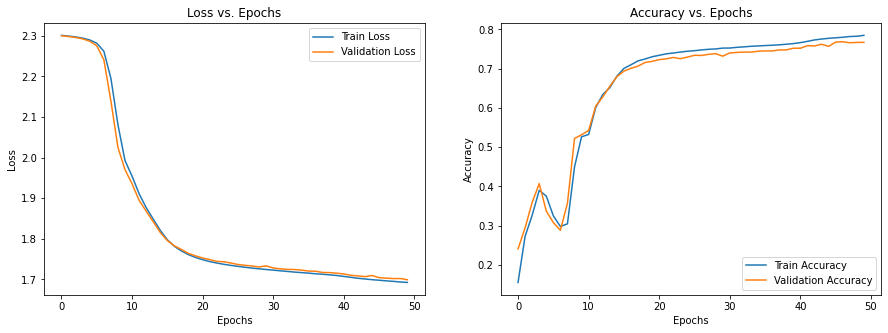

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(model_hist['loss'])
ax[0].plot(model_hist['val_loss'])
ax[0].title.set_text("Loss vs. Epochs")
ax[0].legend(["Train Loss", "Validation Loss"])
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")

ax[1].plot(model_hist['accuracy'])
ax[1].plot(model_hist['val_accuracy'])
ax[1].title.set_text("Accuracy vs. Epochs")
ax[1].legend(["Train Accuracy", "Validation Accuracy"])
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()